In [1]:
# %matplotlib notebook
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt, calendar
import os
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# For a bit more data exploration
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regressor
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# For regression trees
import pygraphviz as pgv
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regressor
from sklearn.tree import export_graphviz

# import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


# Introduction

The aim of this notebook is to:

1) Generate data matrices including potential features of use in predicting lake chemistry and ecology in Lake Vansjø. Data is read in for the River Hobøl and Lake Vansjø in the Morsa vannområde. Data includes meteorological data, NVE discharge data, river chemistry data and lake chemistry and ecology data for the period ca. 1980-2018. Data is cleaned and aligned, and then seasonal averages or sums are calculated and associated derived features (e.g. lags, winter sums).

2) Carry out exploratory data analysis to help identify potentially important relationships. This includes exploration of correlation coefficients and some graphs. Data matrices for each of the four target variables (lake TP concentration, chl-a concentration, biovolume of cyanobacteria and colour) are written to csv for use elsewhere. Further analysis is carried out in the 'Feature Selection' notebooks. This exploratory stats, combined with discussions within NIVA about processes to include in the network, was used to come up with a preliminary selection of predictor variables to include in the Bayesian Belief Network.

3) Having decided on a preliminary selection of variables to include in the Bayesian Network, pick these from all the potentials and do some cleaning and post-processing (e.g. NaN filling, transformations, discretization) to make training data sets for use in Bayesian Network development.

This notebook builds on notebook A_Make_data_matrix.ipynb, where the aim was monthly rather than seasonal aggregation of the data. Notebook A contains some more exploration of the daily data and explanations for some of the data cleaning choices made. This notebook was to help BN development. A simple cleaned version of generation of a training data matrix for fitting the BN structure decided on is in Notebook 04_MakeHistoricTrainingData.

Created by Leah JB. Part of the ERA4CS WATExR project.

# Paths to files and folders

In [2]:
# User input
# Which Vansjø basin? Van1 (Storefjorden), Van2 (Vanemfjorden)
basin = 'Van2'

# Include TP flux estimates in the data matrix?
inc_fluxes = 0 # 0 or 1

# Include features from Van1 in Van2's features? Only relevant if basin is Van2
inc_Van1 = 0

# FILE PATHS to input data

# Met (T, pptn, wind)
met_source = 'metno' # Choose one of: 'metno', 'era5'
met_fpath_dict = {'metno': r'../../Data/Meteorological/Obs_metno/Obs_Metno_1km_gridded_Morsa_v2.csv',
                  'era5': r'../../Data/Meteorological/06_era5/era5_morsa_1980-2019_daily.csv'}
if met_source == 'metno': # Wind is in a separate file
    wind_fpath = r'../../Data/Meteorological/Obs_metno/Obs_Rygge_MeanWindSpeed.csv' # Mean daily wind speed (m/s), Rygge airport

# PET
PET_fpath = r'../Data/ExploratoryInput/Morsa_ThornthwaitePET.csv' #N.B. calculated using met station temp rather than gridded. But the two are v. comparable (not so pptn)

# Discharge
Q_fpath = r'../../Data/Discharge/3-22-0_D6pm_Hogfoss_Scaled_to_Kure.csv'

# Catchment water quality (at Kure)
catchwq_fpath = r'../../Data/Observed_Chem_Ecol/003-59191_Hobølelva_Kure_chem_obs.csv'

# Lake water quality
lakewq_fpath_dict = {'Van1': r'../Data/ExploratoryInput/Van1_Storefjorden_chem_obs_to2017.csv',
                     'Van2': r'../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_chem_obs.csv'}

# Alternative lake colour data (from Storefjorden, 20m depth, MOVAR data)
movar_color_fpath = r'../../Data/Observed_Chem_Ecol/LakeColour_MOVAR.csv'

# Lake ecology (PTI, biovolume, cyanomax, cyano biovolume)
ecol_fpath_dict = {'Van1': r'../Data/ExploratoryInput/Van1_PTI_Cyano_to2018.xlsx',
                   'Van2':  r'../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_Cyanobacteria.csv'}

# Output folders
out_file = r'../Data/DataMatrices'
graph_outfolder = r'../Figures'

# Read in daily data

In [3]:
# READ IN
met_fpath = met_fpath_dict[met_source]
met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
if met_source=='metno':
    wind_df = pd.read_csv(wind_fpath, index_col=0, parse_dates=True, dayfirst=True)

pet_df = pd.read_csv(PET_fpath, index_col=0, parse_dates=True, dayfirst=True)
Q_df = pd.read_csv(Q_fpath, index_col=0, parse_dates=True, dayfirst=True)

catchwq_df = pd.read_csv(catchwq_fpath, index_col=0, parse_dates=True, dayfirst=True)

lakewq_df = pd.read_csv(lakewq_fpath_dict[basin], index_col=0, parse_dates=True, dayfirst=True)
color_df = pd.read_csv(movar_color_fpath, index_col=0, parse_dates=True, dayfirst=True)

# If looking at Van2 (Vanemfjorden), also read in lake data from Storefjorden
if basin =='Van2' and inc_Van1==1:
    lakewq_df_van1 = pd.read_csv(lakewq_fpath_dict['Van1'], index_col=0, parse_dates=True, dayfirst=True)

# Read in ecol data from excel sheet one sheet at a time, then merge
if basin=='Van1':
    # Haven't updated Van1 beyond 2018
    ecol_fpath = ecol_fpath_dict['Van1']
    PTI_df = pd.read_excel(ecol_fpath, sheet_name=0, index_col=3, parse_dates=True)
    biovol_df = pd.read_excel(ecol_fpath, sheet_name=1, index_col=3, parse_dates=True)
    cyanoBiovol_df = pd.read_excel(ecol_fpath, sheet_name=2, index_col=0, parse_dates=True)
    ecol_df = pd.concat([PTI_df['PTI'], biovol_df['Biovolume_mm3_per_l'], cyanoBiovol_df['Cyano_biovol_mm3_per_l']], axis=1)
else:
    # For Van2, haven't updated PTI or biovolume data to 2019, only cyanobiovol
    ecol_fpath = ecol_fpath_dict['Van2']
    ecol_df = pd.read_csv(ecol_fpath, index_col=0, parse_dates=True, dayfirst=True)
    # convert units to mm3/l (mg/l if assume density is same as water)
    ecol_df['Cyano_biovol_mm3_per_l'] = ecol_df['Cyano_biovol_mm3_per_m3']/1000.
    ecol_df.drop(['Cyano_biovol_mm3_per_m3'], axis=1, inplace=True)

# Data cleaning and reorganising

For plots of data see notebook 01 (Make_data_matrix_monthly). That code is repeated here.

## Extract cols of interest from met and Q dfs

In [4]:
# MET DATA

# For the met data, just pick the columns of interest and rename them

if met_source=='metno':
    met_df = met_df[['RR_catch','TG_catch']] # For now, pick rainfall and temp averaged over whole catchment, not just the lake
    met_df.columns = ['Pptn','Temp']
    met_df.index.name = 'Date'
    met_df.index = met_df.index.normalize() # Drop time info from metdf index
    # Add mean daily wind speed (m/s)
    met_df['Wind_speed'] = wind_df.iloc[:,0]
    
else:
    met_df['Wind_speed'] = np.sqrt((met_df['uas']**2) + (met_df['vas']**2))
    met_df = met_df[['tp','tas','Wind_speed']]
    met_df.columns = ['Pptn','Temp','Wind_speed']
    met_df.index.name = 'Date'

# Remove some dodgy-looking values
met_df.loc[met_df['Pptn']<0.,'Pptn'] = 0.

# Also add PET (mm/day)
met_df['PET'] = pet_df['PET']

met_df.head()

,Pptn,Temp,Wind_speed,PET
Date,,,,
1970-12-31,0.000000,-9.243695,4.6,NaN
1971-01-01,0.000000,-10.881015,0.2,0.0
1971-01-02,0.000000,-9.843024,0.3,0.0
1971-01-03,0.000000,-2.851721,6.0,0.0
1971-01-04,0.000096,-2.219738,2.2,0.0


In [5]:
# Q DATA
Q_df = Q_df['Q_18H_average_m3s_scaled']
Q_df.rename('Q', inplace=True)

Date
1976-09-23    0.089
1976-09-24    0.089
1976-09-25    0.089
1976-09-26    0.090
1976-09-27    0.088
              ...  
2018-09-25    0.392
2018-09-26    0.360
2018-09-27    0.399
2018-09-28    0.424
2018-09-29    0.370
Name: Q, Length: 11702, dtype: float64

In [6]:
# Annual mean wind speed
# met_df['Wind_speed'].groupby(met_df.index.year).mean().plot()

## Process lake colour data

In [7]:
# Lake colour data (merge MOVAR and NIVA data). Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
lakewq_df = pd.merge(lakewq_df, color_df, left_index=True, right_index=True, how='outer')

# Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
s0 = lakewq_df.loc[:'1998-12-31','colour']

id1 = lakewq_df['Colour'].first_valid_index()
s1 = lakewq_df['Colour'].loc[id1:]
s1.name = 'colour'

lastidx = lakewq_df.loc['2013-01-01':,'colour'].last_valid_index()
s2 = lakewq_df.loc['2013-01-01':lastidx,'colour']

colour = pd.concat([s0, s1,s2], axis=0).dropna()

# Drop original MOVAR and NIVA colour series, and replace with the patched series
lakewq_df = lakewq_df.drop(['colour','Colour'], axis=1)
lakewq_df = lakewq_df.merge(colour.to_frame(), left_index=True, right_index=True, how='outer')

# Drop some dodgy-looking values
lakewq_df.loc[:'1982-08-01','colour'] = np.NaN
lakewq_df[lakewq_df[['SS','SS_min']]>25.] = np.NaN

if basin == 'Van2' and inc_Van1==1:
    lakewq_df_van1.loc[:'1982-08-01','colour'] = np.NaN

## Combine data into one df, drop unwanted cols and rows

['Pptn' 'Temp' 'Wind_speed' 'PET' 'Q' 'TP_catch' 'chl-a_lake' 'TP_lake'
 'colour_lake' 'CyanoBiovol']


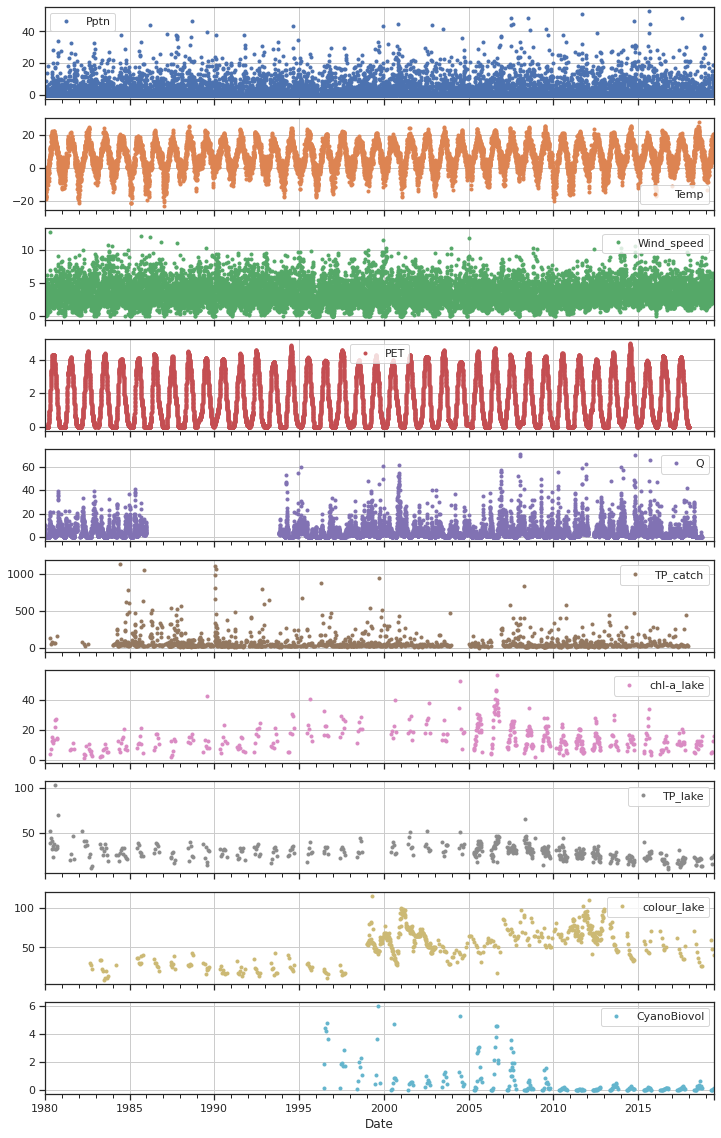

In [8]:
# Add suffixes to lake and water quality columns
catchwq_df = catchwq_df.add_suffix('_catch')
lakewq_df = lakewq_df.add_suffix('_lake')

if basin == 'Van2' and inc_Van1==1:
    lakewq_df_van1 = lakewq_df_van1.add_suffix('_van1')

# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME

if basin == 'Van2' and inc_Van1==1:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df, lakewq_df_van1]
else:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=met_df.index)
    if i<1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc['1980-01-01':,:]

# Drop some cols and rename others
if basin == 'Van2' and inc_Van1==1:
    cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
                    'TOC_lake','TDP_lake','SS_lake','SS_min_lake',
                    'TOC_van1', 'TDP_van1', 'SS_min_van1', 'SS_van1',]
else:
    cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
                    'TOC_lake','TDP_lake','SS_lake','SS_min_lake']
    
var_rename_dict = {'Biovolume_mm3_per_l':'Biovolume','Cyano_biovol_mm3_per_l':'CyanoBiovol'}

daily_df.drop(cols_to_drop, axis=1, inplace=True)
daily_df.rename(var_rename_dict, axis=1, inplace=True)

# Check output
print(daily_df.columns.values)
daily_fig = daily_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3, figsize=(12,20), grid=True);

# plt.savefig(os.path.join(graph_outfolder,'daily_data_tseries.png'))


In [9]:
# Wind speed in 1996 was really low. Real? Yep, looks like it. Just a really calm winter.
# daily_df.loc['1994-01-01':'1998-12-31','Wind_speed'].plot(figsize=(10,3), grid=True)

## Add precipitation-related features

                Pptn  Rain_day
Date                          
1980-01-01  0.000000         0
1980-01-02  0.000000         0
1980-01-03  0.000000         0
1980-01-04  2.669136         1
1980-01-05  2.806878         1
8.499137083600006
                Pptn  Pptn_intense
Date                              
1980-01-01  0.000000             0
1980-01-02  0.000000             0
1980-01-03  0.000000             0
1980-01-04  2.669136             0
1980-01-05  2.806878             0


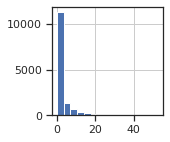

In [9]:
# Add derived variables from daily data.
# Don't bother with residence time or fluxes as didn't seem important in monthly analysis, and for fluxes lots of missing vaules

# Precipitation features:
# (1) rain day (boolean of whether it rained that day or not). There are various definitions and things we could use,
# (e.g., from Australian Met service):
# Wet days    Annual count of days with daily precipitation ≥ 1 mm
# Heavy precipitation days    Annual count of days with daily precipitation ≥ 10 mm
# Very heavy precipitation days    Annual count of days with daily precipitation ≥ 30 mm

# Decide to go with 'Wet day' definition, to filter out small errors in values under 1mm (& which might be dew)

def rain_day(pptn):
    if pptn>1: return 1
    else: return 0
daily_df['Rain_day'] = daily_df['Pptn'].map(rain_day)
print (daily_df[['Pptn','Rain_day']].head())

# (2) pptn intensity: Boolean saying whether precipitation is above a certain threshold
# First, take a look at the distribution of rainfall to decide on the threshold
daily_df['Pptn'].hist(bins=15, figsize=(2,2))
print (daily_df['Pptn'].quantile(q=0.90))

# Decide to go again with AU definition of 'Heavy precipitation days'
def rain_intense(pptn):
    if pptn>10.0: return 1
    else: return 0
daily_df['Pptn_intense'] = daily_df['Pptn'].map(rain_intense)
print (daily_df[['Pptn','Pptn_intense']].head())

## Add wind speed-related features

Nothing wind-related really came out as important in the monthly analysis. So here, cut down on the number of wind-related features to include. Also just add in mean seasonal wind speed.

Median daily wind speed is 3.3 m/s, and the distribution is somewhat right skewed. The main thing that is likely to be important for cyanobacteria is a stable upper water column, so that turbulence doesn't cause cells to sink. The duration of the stable upper water column could also be important, so features could be e.g. x days below whatever wind speed threshold is required for a stable upper water column, AND no (potentially short-lived) periods where the water column is mixed due to high winds.

Q0.2: 2.0 m/s
Q0.4: 2.9 m/s


Q0.6: 3.8 m/s
Q0.8: 4.8 m/s
            Wind_speed  Wind_under_Q0.2  Wind_over_Q0.6
Date                                                   
1980-01-01         2.9            False           False
1980-01-02         3.1            False           False
1980-01-03         1.5             True           False
1980-01-04         1.7             True           False
1980-01-05         1.5             True           False


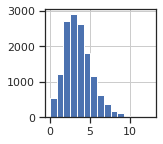

In [10]:
# Wind features: Boolean saying whether wind speed was above or below a certain threshold

# Distribution of wind speed
daily_df['Wind_speed'].hist(bins=15, figsize=(2,2))

# Define 'calm day' features
calm_quantiles = [0.2, 0.4] 
for quantile in calm_quantiles:
    upper_threshold = daily_df['Wind_speed'].quantile(quantile)
    print('Q%s: %s m/s' %(quantile, upper_threshold))
    daily_df['Wind_under_Q%s' %quantile] = daily_df['Wind_speed'] < upper_threshold

print('\n')
    
# Define 'windy day' features
windy_quantiles = [0.6, 0.8]
for quantile in windy_quantiles:
    lower_threshold = daily_df['Wind_speed'].quantile(quantile)
    print('Q%s: %s m/s' %(quantile, lower_threshold))
    daily_df['Wind_over_Q%s' %quantile] = daily_df['Wind_speed'] > lower_threshold
    
print (daily_df[['Wind_speed','Wind_under_Q0.2','Wind_over_Q0.6']].head())

## Add temperature-related features

Later in the analysis I was finding that PET was coming out as a significant feature relating to biol. E.g. winter PET correlating with summer cyanobacterial biovolume. I think this could be more about ice thickness and duration, which I can't find long term records for. Instead, lets calculate winter freezing days (days where T<0), and assume the more subzero days the thicker the ice and the longer the ice duration.

In [11]:
daily_df['Temp_subzero'] = daily_df['Temp']<0.
daily_df[['Temp','Temp_subzero']].head()

,Temp,Temp_subzero
Date,,
1980-01-01,-4.758278,True
1980-01-02,-8.821736,True
1980-01-03,-15.280719,True
1980-01-04,-12.965066,True
1980-01-05,-5.304253,True


# Output daily data matrix

In [13]:
# Optionally output to csv
# daily_df.to_csv(os.path.join(out_file,'Vansjø_daily_data_%s.csv' %basin), index_label='Date')

# Resample to seasonal

In [12]:
# Set the aggregation method for different variables

vars_to_sum = ['Pptn','Rain_day','Pptn_intense', 'PET',
              'Q', 'Temp_subzero']

# Add wind cols to vars to sum
wind_cols = []
for q in calm_quantiles:
    wind_cols.append('Wind_under_Q%s' %q)
for q in windy_quantiles:
    wind_cols.append('Wind_over_Q%s' %q)
vars_to_sum += wind_cols
    
vars_to_average = ['TP_catch',
                 'PTI',
                 'Temp',
#                  'Q',
                 'Biovolume',
                 'rel_res_time',
                 'colour_lake',
                 'TP_lake',
                 'chl-a_lake',
                  'Wind_speed',
                  ]

vars_to_max = ['CyanoBiovol']

if basin == 'Van2' and inc_Van1==1:
    vars_to_average.extend(['colour_van1','TP_van1','chl-a_van1'])

agg_method_dict = {} # Key: var, returns aggregation method
for var in daily_df.columns:
    if var in vars_to_sum:
        method = np.nansum
    elif var in vars_to_average:
        method = np.nanmean
    elif var in vars_to_max:
        method = np.nanmax
    else:
        method = None
    agg_method_dict[var] = method

# agg_method_dict

For the summer season, you might expect chl-a and cyanobacteria, which have peaks in June-Aug, to show stronger correlations with met variables during these three months, rather than during the full 6 month growing season period. I tried this out, using the code below to calculate just June-Aug seasonal sums/averages, replacing 'daily_df' with 'masked_daily_df' when calculating the seasonal summaries, and then running through the correlations and scatterplots with this different seasonal averaging. But it didn't make any difference, no stronger links between in-lake biol and met variables. Therefore go back to full season summary stats.

In [15]:
# # For summer sesason, met vars perhaps better summed/averaged over just June-Aug when looking
# # for links to algal stuff. Try that.

# # Vars to mask. Met vars. Too fiddly to do others (would need to versions of each then,
# # one used in predicting others, the other the dependent variable, the WFD growing seaason mean)
# peak_summer_vars = vars_to_sum.copy()
# peak_summer_vars.extend(['Temp','Wind_speed'])
# mask_months = [5,9,10] # Summer months to exclude in seasonal aggregation

# masked_daily_df = daily_df.copy()
# masked_daily_df.loc[masked_daily_df.index.month.isin(mask_months), peak_summer_vars] = np.NaN

# masked_daily_df.loc['1991-04-29':'1991-11-01',['Temp','Pptn']]


In [13]:
# RESAMPLE TO SEASONAL

# Define 2 seasons per year. Lake sampling is from mid-April to mid-October, WFD status May-Sep.
# Winter values (e.g. Nov-Dec 1999 & Jan-April 2000) are stored as 2000.

def season(x):
    """Input month number, and return the season it corresponds to
    """
    if x in [11,12,1,2,3,4]:
        return 'wint'
    else:
        return 'summ'

# Resample (enter 'Q' for quarterly, and '-month' for month to end in)
# N.B. if you change season function, need to change this too
season_df = daily_df.resample('2Q-Apr', closed='left').agg(agg_method_dict)
season_df['Season'] = season_df.index.month.map(season)

# Remove frequncy info from index so all plotting works right
season_df.index.freq=None

# Particularly for summed variables, drop 1980 as missing first 2 months
for col in season_df.columns:
    if col in vars_to_sum:
        season_df[col].iloc[0] = np.NaN #Assumes first year is 1980. Index-label based slicing not working annoyingly
        
# Also drop summer 2019, as have lots of missing data
season_df = season_df.drop([season_df.index[-1]])

# For Q, need to correct the units (summed up m3/s over days, convert to 10^6 m3 per season)
season_df['Q'] = season_df['Q'] * (86400./10**6)

# Summing over seasons gives 0 for Q & PET due to no data. Replace with NaNs
season_df.loc[season_df['Q']==0.0,'Q'] = np.NaN
season_df.loc[season_df['PET']==0.0,'PET'] = np.NaN

season_df

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Pptn,Temp,Wind_speed,PET,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,CyanoBiovol,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,Wind_over_Q0.6,Wind_over_Q0.8,Temp_subzero,Season
Date,,,,,,,,,,,,,,,,,,
1980-04-30,NaN,-3.086262,2.848333,NaN,NaN,130.000000,3.971429,45.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wint
1980-10-31,579.570268,13.090170,3.341848,528.944155,87.710170,86.400000,16.080130,43.573016,NaN,NaN,83.0,16.0,33.0,80.0,57.0,27.0,5.0,summ
1981-04-30,244.503965,-0.893721,3.413812,36.989387,69.853277,NaN,NaN,NaN,NaN,NaN,39.0,5.0,41.0,68.0,64.0,38.0,96.0,wint
1981-10-31,494.730157,12.599971,3.488587,515.460389,61.463318,NaN,8.331250,28.833333,NaN,NaN,61.0,17.0,30.0,68.0,68.0,35.0,0.0,summ
1982-04-30,366.125943,-1.877038,3.360221,49.298551,96.428880,69.000000,1.100000,46.250000,NaN,NaN,60.0,10.0,47.0,82.0,69.0,41.0,92.0,wint
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-30,307.789680,1.937102,3.664088,61.733942,61.324560,78.363636,11.000000,17.000000,62.000000,0.018,46.0,12.0,34.0,64.0,71.0,44.0,53.0,wint
2017-10-31,570.221295,13.366517,3.710326,529.270370,67.758768,77.928571,12.866667,19.666667,42.000000,0.258,76.0,20.0,9.0,54.0,75.0,36.0,0.0,summ
2018-04-30,372.847838,0.152024,3.439227,11.259850,105.685949,35.000000,5.500000,24.000000,71.000000,0.002,60.0,10.0,28.0,70.0,57.0,29.0,97.0,wint


## Exploratory boxplots

/opt/conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


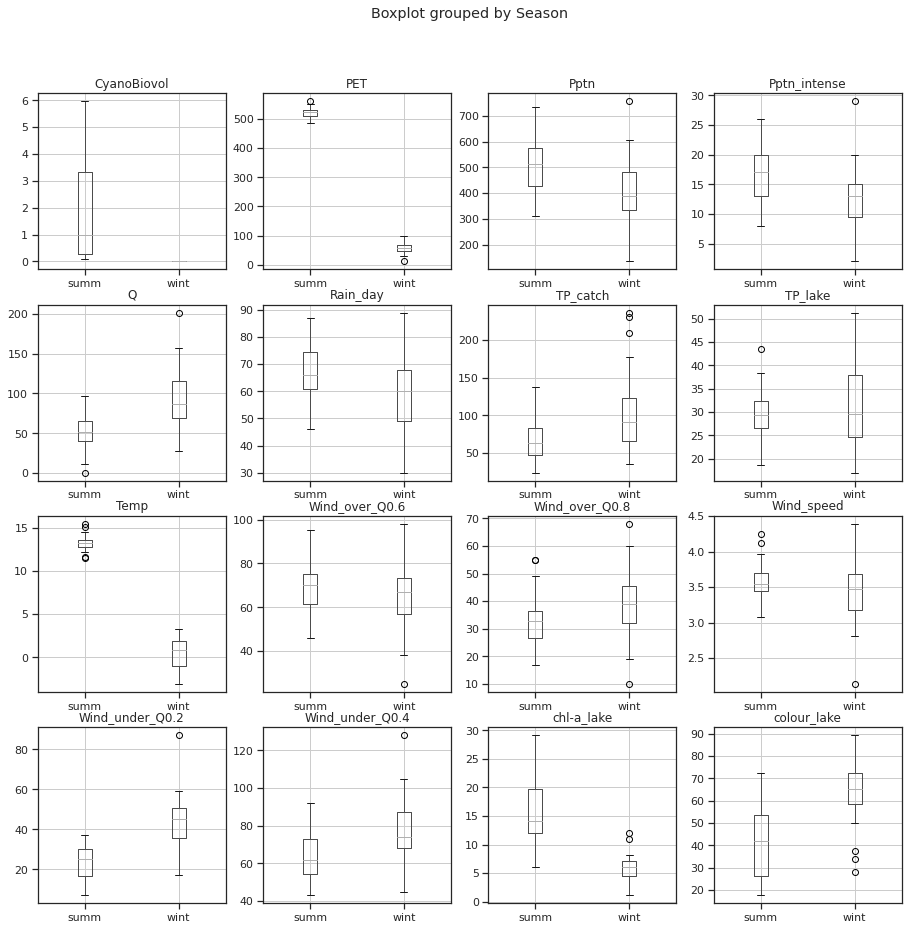

In [14]:
fig, axs = plt.subplots(4,4, sharey=False, figsize=(15,15))
bp = season_df.drop(['Temp_subzero'], axis=1).boxplot(by='Season', ax=axs); #For Van1, also drop 'Biovolume' & 'Wind_over_Q0.6'
[ax.set_xlabel('') for ax in bp];

plt.savefig(os.path.join(graph_outfolder, 'Season_6M_boxplots_%s.png' %met_source))

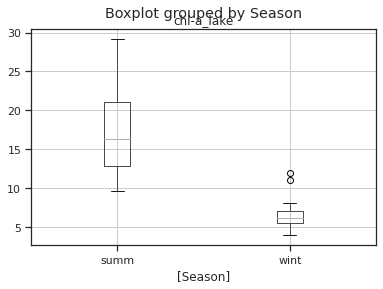

In [15]:
# Zoom in on chl-a, and just for the period where it crosses over with cyanobacteria data

ax = season_df.loc['1997-04-30':,['chl-a_lake','Season']].boxplot(by='Season')

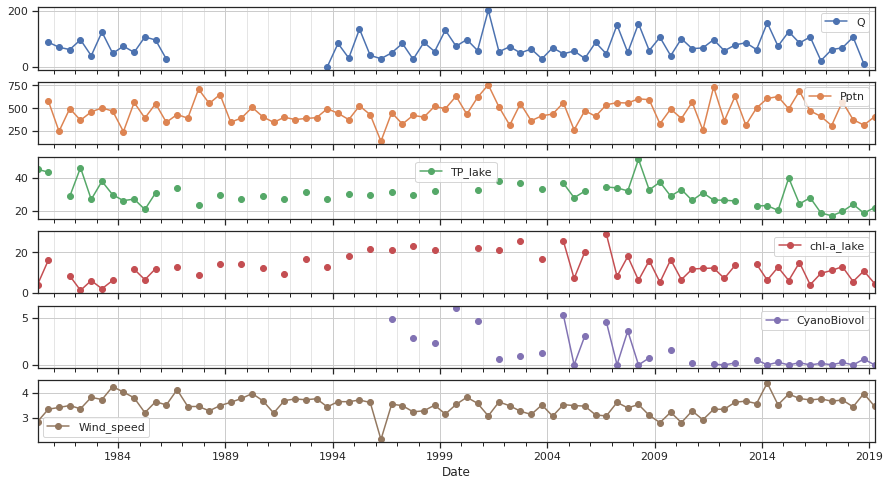

In [16]:
# Time series, to look at winter 2000 flooding event. Can see peak pptn and Q in Nov 2000-Jan 2001.But chl-a was already high before then,
# and cyano if anything decreased for a couple of years after and then went back up again...

ax = season_df.loc[:,['Q','Pptn','TP_lake','chl-a_lake','CyanoBiovol','Wind_speed']].plot(subplots=True, figsize=(15,8), grid=True, marker='o')
ax[0].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[1].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[2].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[3].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[4].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[1].legend(loc='upper right')

## Add lagged variables

In [17]:
# For desired variables, add 1 (and optionally a 2 season) lag

# Only do for variables that we will have data for or may be able to estimate
lag_vars = ['Pptn', 'Temp', 'Wind_speed', 'PET', 'Q',
           'Rain_day', 'Pptn_intense',
           'Wind_under_Q0.2', 'Wind_under_Q0.4', 'Wind_over_Q0.6',
           'Wind_over_Q0.8']

for var in lag_vars:
    season_df['%s_lag1' %var] = season_df[var].shift(+1)
#     season_df['%s_lag2' %var] = season_df[var].shift(+2)

    
season_df[['Pptn','Pptn_lag1']].head()

,Pptn,Pptn_lag1
Date,,
1980-04-30,NaN,NaN
1980-10-31,579.570268,NaN
1981-04-30,244.503965,579.570268
1981-10-31,494.730157,244.503965
1982-04-30,366.125943,494.730157


In [18]:
# Calculate summer average from previous year. Could define summer as whole WFD growing season (May-Oct, incl.),
# or as just the key summer months (June-Aug/Sep). For now, stick to whole WFD growing season

prev_summer_toaverage = ['TP_lake', 'colour_lake', 'chl-a_lake', 'Temp','CyanoBiovol'] # Maybe add cyanobacteria here, rather than have as max?

# Filter to just summer and shift
prevSummerCols = season_df.loc[season_df['Season']=='summ',prev_summer_toaverage].shift(+1)
prevSummerCols = prevSummerCols.add_suffix('_prevSummer')
prevSummerCols.head()

season_df = season_df.join(prevSummerCols)

In [19]:
# 'Previous summer' vars are all NaNs for winter season. Fill them backwards
season_df[prevSummerCols.columns] = season_df[prevSummerCols.columns].fillna(method='bfill', axis=0, limit=1)

season_df.loc['2016':'2018',['TP_lake','TP_lake_prevSummer','Temp', 'Temp_prevSummer']]

,TP_lake,TP_lake_prevSummer,Temp,Temp_prevSummer
Date,,,,
2016-04-30,28.000000,24.250000,1.789752,12.687234
2016-10-31,18.750000,24.250000,14.026004,12.687234
2017-04-30,17.000000,18.750000,1.937102,14.026004
2017-10-31,19.666667,18.750000,13.366517,14.026004
2018-04-30,24.000000,19.666667,0.152024,13.366517
2018-10-31,18.666667,19.666667,15.453903,13.366517


In [20]:
season_df.columns

Index(['Pptn', 'Temp', 'Wind_speed', 'PET', 'Q', 'TP_catch', 'chl-a_lake',
       'TP_lake', 'colour_lake', 'CyanoBiovol', 'Rain_day', 'Pptn_intense',
       'Wind_under_Q0.2', 'Wind_under_Q0.4', 'Wind_over_Q0.6',
       'Wind_over_Q0.8', 'Temp_subzero', 'Season', 'Pptn_lag1', 'Temp_lag1',
       'Wind_speed_lag1', 'PET_lag1', 'Q_lag1', 'Rain_day_lag1',
       'Pptn_intense_lag1', 'Wind_under_Q0.2_lag1', 'Wind_under_Q0.4_lag1',
       'Wind_over_Q0.6_lag1', 'Wind_over_Q0.8_lag1', 'TP_lake_prevSummer',
       'colour_lake_prevSummer', 'chl-a_lake_prevSummer', 'Temp_prevSummer',
       'CyanoBiovol_prevSummer'],
      dtype='object')

## Output seasonal data matrix with all data

In [22]:
# output to csv
season_df.to_csv(os.path.join(out_file,'Seasonal_allVars','Vansjø_seasonal_data_1Season_%s_%s.csv' %(basin,met_source)))

# Split into separate matrices for the 4 possible response variables & look at correlations

First, decide whether want to keep all seasons, or just look at one season

In [145]:
season_slice = 'summ' # one of 'all', 'wint', 'summ'

print(len(season_df))

if season_slice in ['wint','summ']:
    season_var_df = season_df.loc[season_df['Season']==season_slice, :]

print(len(season_df))

80
80


In [26]:
sorted(season_df.columns)

['CyanoBiovol',
 'CyanoBiovol_prevSummer',
 'PET',
 'PET_lag1',
 'Pptn',
 'Pptn_intense',
 'Pptn_intense_lag1',
 'Pptn_lag1',
 'Q',
 'Q_lag1',
 'Rain_day',
 'Rain_day_lag1',
 'Season',
 'TP_catch',
 'TP_lake',
 'TP_lake_prevSummer',
 'Temp',
 'Temp_lag1',
 'Temp_prevSummer',
 'Temp_subzero',
 'Wind_over_Q0.6',
 'Wind_over_Q0.6_lag1',
 'Wind_over_Q0.8',
 'Wind_over_Q0.8_lag1',
 'Wind_speed',
 'Wind_speed_lag1',
 'Wind_under_Q0.2',
 'Wind_under_Q0.2_lag1',
 'Wind_under_Q0.4',
 'Wind_under_Q0.4_lag1',
 'chl-a_lake',
 'chl-a_lake_prevSummer',
 'colour_lake',
 'colour_lake_prevSummer']

## Lake TP conc

In [147]:
# First, lake TP concentration is the dependent variable.
cols_to_drop = [
#  'Biovolume',
 'CyanoBiovol',
 'CyanoBiovol_prevSummer',
#  'PTI',
 'chl-a_lake',
 'chl-a_lake_prevSummer',
 'colour_lake',
 'colour_lake_prevSummer',
 'Temp_subzero',
    ]

season_df_TP = season_var_df.drop(cols_to_drop,axis=1)
print (len(season_df_TP))

# Drop any rows where TP_lake is a NaN
season_df_TP.dropna(subset=['TP_lake'], inplace=True)
print (len(season_df_TP))
season_df_TP.head()

40
39


,Pptn,Temp,Wind_speed,PET,Q,TP_catch,TP_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,...,PET_lag1,Q_lag1,Rain_day_lag1,Pptn_intense_lag1,Wind_under_Q0.2_lag1,Wind_under_Q0.4_lag1,Wind_over_Q0.6_lag1,Wind_over_Q0.8_lag1,TP_lake_prevSummer,Temp_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-10-31,546.234709,13.189984,2.315955,528.944155,87.710170,86.400000,43.573016,90.0,14.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-10-31,509.272092,12.730662,2.480133,515.460389,61.463318,NaN,28.833333,78.0,17.0,30.0,...,36.989387,69.853277,49.0,3.0,35.0,71.0,69.0,31.0,43.573016,13.189984
1982-10-31,557.452704,13.058740,2.684404,523.413325,39.515126,45.500000,26.988095,77.0,21.0,29.0,...,49.298551,96.428880,65.0,7.0,32.0,65.0,79.0,38.0,28.833333,12.730662
1983-10-31,466.465026,13.247098,2.728690,524.306110,47.977834,NaN,29.781250,66.0,13.0,28.0,...,60.945000,124.071782,66.0,14.0,42.0,75.0,82.0,47.0,26.988095,13.058740
1984-10-31,594.005748,13.231029,2.403212,525.907514,51.510902,137.664286,27.158333,74.0,19.0,36.0,...,46.183876,73.566317,59.0,6.0,26.0,62.0,89.0,50.0,29.781250,13.247098


In [148]:
# Take a look at what's missing
# First, drop any columns which don't have NaNs, then plot
# monthly_df_lakeTP.loc[:, monthly_df_lakeTP.isna().any()].plot(subplots=True, figsize=(12,30))

In [149]:
X = season_df_TP.drop(['TP_lake'],axis=1)
y = season_df_TP['TP_lake']
corr_df = X.corrwith(y, method='pearson')
corr_df.sort_values()

Wind_speed             -0.420411
Wind_over_Q0.6         -0.412322
Wind_speed_lag1        -0.334381
Wind_over_Q0.8         -0.259166
Wind_over_Q0.6_lag1    -0.234763
Wind_over_Q0.8_lag1    -0.227659
Temp_lag1              -0.190404
Pptn_intense           -0.119297
TP_catch               -0.103351
Temp                   -0.091591
Pptn                   -0.070693
PET_lag1               -0.049111
Rain_day_lag1          -0.020853
Rain_day               -0.016514
Q_lag1                 -0.014968
Temp_prevSummer         0.021391
PET                     0.049347
Q                       0.106530
Pptn_lag1               0.111560
Pptn_intense_lag1       0.163455
Wind_under_Q0.2_lag1    0.225650
Wind_under_Q0.4_lag1    0.230871
Wind_under_Q0.4         0.381936
Wind_under_Q0.2         0.430046
TP_lake_prevSummer      0.641919
dtype: float64

**Same story to when broken into two summer seasons:**
- TP_lake_prevSummer (0.65)
- Wind (met.no data): summer wind_under_Q0.2 (0.51), winter mean wind (-0.40). i.e. calmer gives higher lake TP conc. Wind is complicated, as have a correlation e.g. between TP the previous summer and the following winter's wind. i.e. not causative then. But could be that the trend in both is linked... Need more sites with data to test that. But it consistently comes out as being the only weather variable that is correlated with TP, so decide not to discount because of this. Possible mechanism: calmer means stronger stratification. Not sure why that would mean higher TP conc though... Need to talk to some limnologists.
- Wind (ERA5): still have a relationship, ccs a bit lower. E.g. wind speed (-0.42), wind_under_Q0.2 (0.43)

Aside from these, all CCs less than 0.2 (absolute). E.g. winter temp (-0.21), vars relating to delivery less than 0.14.

Spearman's rank rather than Pearson's:
- TP_lake_prevSummer (0.64)
- Met.no: summer wind_under_Q0.2 (0.42), wind_speed (-0.31)
- Wind (ERA5): similar ccs to Pearson's. wind speed (-0.4), wind_under_Q0.2 (0.45)

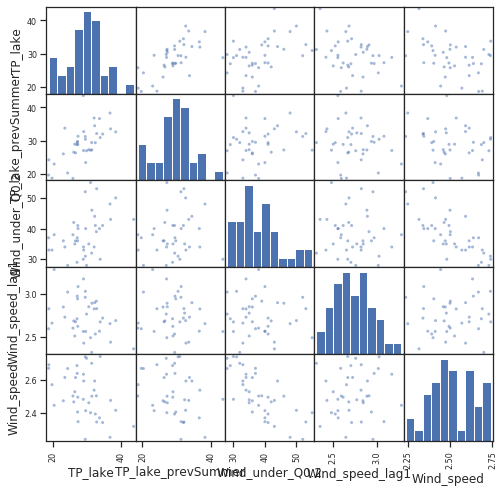

In [150]:
vars_for_scatterplot = ['TP_lake','TP_lake_prevSummer', 'Wind_under_Q0.2', 'Wind_speed_lag1','Wind_speed']

pd.plotting.scatter_matrix(season_var_df.loc[:,vars_for_scatterplot], figsize=(8,8));

# plt.savefig(os.path.join(graph_outfolder,'seasonal_6M_scattermatrix_TP_%s_%s.png'%(season_slice,basin)))

## Response var = Lake chl-a concentration

In [151]:
# 2) chl-a concentration
cols_to_drop = [
#  'Biovolume',
 'CyanoBiovol',
 'CyanoBiovol_prevSummer',
#  'PTI',
 'Temp_subzero'
    ]

season_df_lake_chla = season_var_df.drop(cols_to_drop,axis=1)
print (len(season_df_lake_chla))

# Drop any rows where explanatory variable value is a NaN
season_df_lake_chla.dropna(subset=['chl-a_lake'], inplace=True)
print (len(season_df_lake_chla))
# monthly_df_lake_chla.head()

40
39


In [152]:
X = season_df_lake_chla.drop(['chl-a_lake'],axis=1)
y = season_df_lake_chla['chl-a_lake']
corr_df = X.corrwith(y, method='spearman')
corr_df.sort_values()

Wind_speed               -0.359717
Wind_over_Q0.8           -0.350102
TP_catch                 -0.247976
Wind_over_Q0.6           -0.234424
Q                        -0.161694
Q_lag1                   -0.121691
Rain_day                 -0.068039
Pptn_intense             -0.040246
Pptn                     -0.039879
Wind_under_Q0.4_lag1     -0.009531
Wind_speed_lag1          -0.002632
Wind_over_Q0.8_lag1      -0.001752
Wind_over_Q0.6_lag1       0.009426
Pptn_lag1                 0.057008
colour_lake_prevSummer    0.061905
Rain_day_lag1             0.092203
Pptn_intense_lag1         0.105567
PET_lag1                  0.113561
Wind_under_Q0.2_lag1      0.142481
colour_lake               0.156022
Temp_lag1                 0.238259
Wind_under_Q0.4           0.266018
Temp                      0.302227
PET                       0.304884
Temp_prevSummer           0.309990
TP_lake_prevSummer        0.370555
Wind_under_Q0.2           0.423736
chl-a_lake_prevSummer     0.631105
TP_lake             

**Comments on chl-a correlations for Van 2:**

- Mean chl-a the previous summer (0.65). i.e. stronger than when early and late summer were looked at separately (0.59, 0.53)
- TP-lake (0.58). Similar to late summer CC (0.59), and stronger than early summer alone
- Wind (met.no): e.g. over Q0.6 (-0.51), wind speed (-0.51), over Q0.8 (-0.49), under Q0.4 (0.41). Similar to 2 seasons, slightly weaker (early summer had up to -0.53, late summer up to -0.56)
- Wind (ERA5): not as strong CCs as with met.no data. Strongest is Wind_speed (-0.42) and Wind_under_Q0.2 (0.42). Scatterplot still looks reasonably convincing though, just lots of spread.
- PET (0.36), Temp (0.22). Both unconvincing on scatter plot. Temp_prevSummer looks a bit more convincing on scatterplot, though CC low (0.12).

**Temperature effect very weak when looking at one season at a time!! Wind and nutrients appear more important**

Spearman's rank:
- TP_lake (0.66)
- chl-a_lake_prevSummer (0.65)
- Wind_speed, met.no: wind over Q0.6 or 0.8 (-0.43)
- Wind_speed, ERA5: wind_under_Q0.2 (0.42), Wind_speed (-0.36)

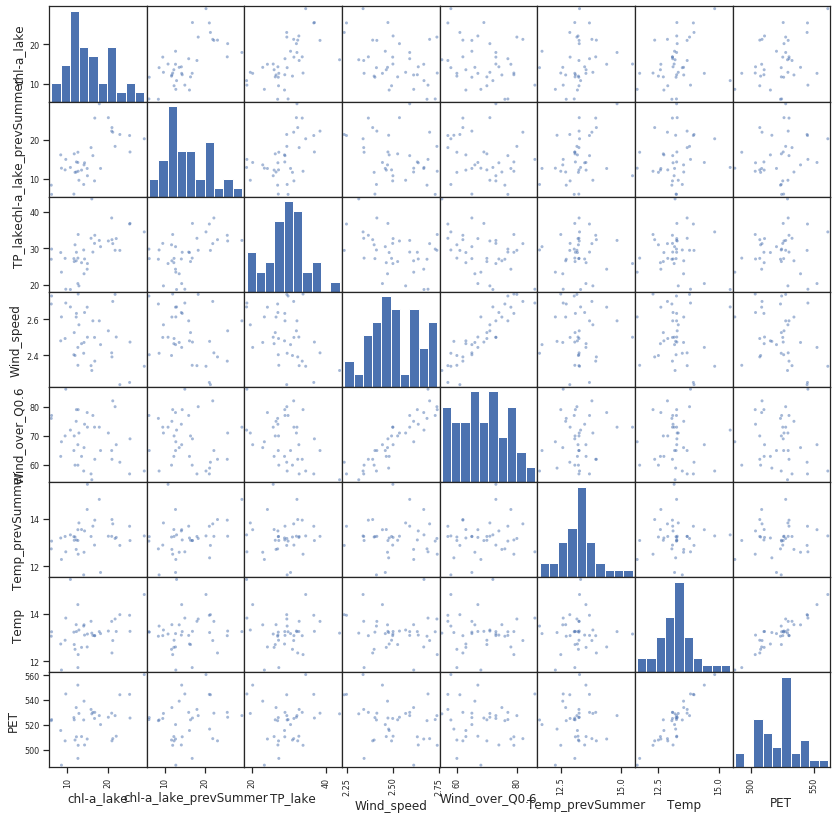

In [153]:
vars_for_scatterplot = ['chl-a_lake','chl-a_lake_prevSummer', 'TP_lake','Wind_speed','Wind_over_Q0.6',
                        'Temp_prevSummer','Temp', 'PET']

pd.plotting.scatter_matrix(season_var_df.loc[:,vars_for_scatterplot], figsize=(14,14));

# plt.savefig(os.path.join(graph_outfolder,'seasonal_6M_scattermatrix_chl-a_%s_%s.png'%(season_slice,basin)))

## Response var = max cyanobacterial biovolume

In [154]:
# cols to drop:
cols_to_drop = [
#  'Biovolume',
#  'PTI',
 'Temp_subzero'
    ]

season_df_cyano = season_var_df.drop(cols_to_drop,axis=1)
print (len(season_df_cyano))

# Drop any rows where explanatory var value is a NaN
season_df_cyano.dropna(subset=['CyanoBiovol'], inplace=True)
print (len(season_df_cyano))

40
24


In [155]:
X = season_df_cyano.drop(['CyanoBiovol'],axis=1)
y = season_df_cyano['CyanoBiovol']
corr_df = X.corrwith(y, method='pearson')
corr_df.sort_values()

colour_lake_prevSummer   -0.459192
colour_lake              -0.428966
Wind_over_Q0.6_lag1      -0.241607
PET                      -0.197774
Pptn_intense_lag1        -0.182724
Q_lag1                   -0.176347
PET_lag1                 -0.174398
Pptn_intense             -0.170768
Wind_over_Q0.6           -0.168447
Q                        -0.162922
Wind_speed_lag1          -0.154442
Temp_prevSummer          -0.143260
Pptn_lag1                -0.138799
Rain_day_lag1            -0.131626
Wind_over_Q0.8_lag1      -0.126569
Pptn                     -0.102330
Wind_speed               -0.092337
Wind_under_Q0.4          -0.087018
Rain_day                 -0.081921
Wind_over_Q0.8           -0.067688
Temp                     -0.052019
Temp_lag1                -0.049513
Wind_under_Q0.2           0.052104
TP_catch                  0.166735
Wind_under_Q0.4_lag1      0.221528
Wind_under_Q0.2_lag1      0.227825
TP_lake_prevSummer        0.502994
CyanoBiovol_prevSummer    0.563204
chl-a_lake_prevSumme

**Cyanomax correlations in Van 2:**

- chl-a_lake (0.77). Same as when split into two seasons, CCs just as high
- TP_lake (0.58). Tiny bit smaller CC than late summer but not much (0.62), higher than early summer (0.42)
- Previous summer: chl-a (0.56), av cyano (0.55), TP (0.49). Similar to early summer, bit smaller CCs than late summer (0.67 for LS mean cyano)
- Lake colour: previous summer (-0.50), this summer (-0.44). More coloured means less cyano, which makes sense. But correlation vs causation? Don't see colour effect with chl-a. Would we expect cyano to be affected, and not chl-a? Have asked Sigrid Haande this in the past, but can't remember the answer. Think perhaps yes, because they use a different bit of the light spectrum. Similar to early & late summer CCs.
- Wind variables: not much. Wind_under_Q0.2 (0.30), and winter wind vars (>Q0.6 -0.38, mean speed -0.31). CCs of about 0.4 for early & late summer.
- Temp: negative correlations if anything! Current season (-0.2), previous summer -0.26

Spearman's rank:
- chl-a_lake (0.83)
- Previous summer cyano (0.71), chl-a (0.70), TP (0.63)
- Colour (previous summer: -0.47, this summer: -0.45)

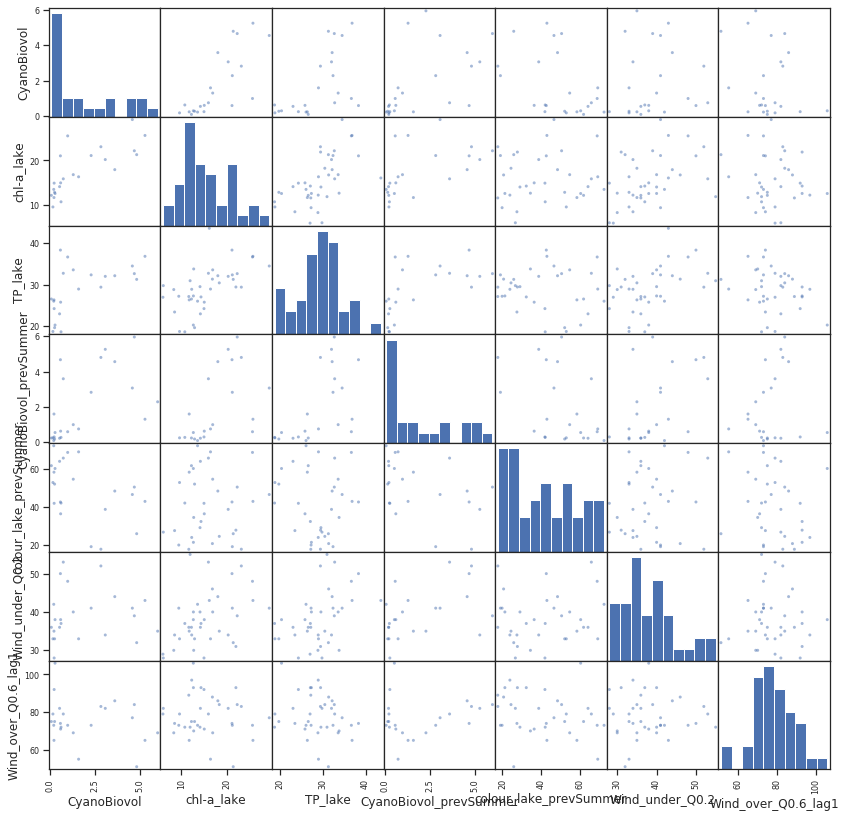

In [156]:
vars_for_scatterplot = ['CyanoBiovol','chl-a_lake','TP_lake',
                        'CyanoBiovol_prevSummer',
                        'colour_lake_prevSummer',
                        'Wind_under_Q0.2', 'Wind_over_Q0.6_lag1']

pd.plotting.scatter_matrix(season_var_df.loc[:,vars_for_scatterplot], figsize=(14,14));

# plt.savefig(os.path.join(graph_outfolder,'seasonal_6M_scattermatrix_cyano_%s_%s.png'%(season_slice,basin)))

## Response var = Lake colour

In [157]:
# Drop all ecological-related stuff

cols_to_drop = [
#  'Biovolume',
 'CyanoBiovol',
 'CyanoBiovol_prevSummer',
#  'PTI',
 'Season',
#  'TP_catch',
#  'TP_lake',
 'TP_lake_prevSummer',
 'chl-a_lake',
 'chl-a_lake_prevSummer',
 'Temp_subzero'
    ]

season_df_lakeColour = season_var_df.drop(cols_to_drop,axis=1)
print (len(season_df_lakeColour))

# Drop any rows where response var is a NaN
season_df_lakeColour.dropna(subset=['colour_lake'], inplace=True)
print (len(season_df_lakeColour))
season_df_lakeColour.head()

40
36


,Pptn,Temp,Wind_speed,PET,Q,TP_catch,TP_lake,colour_lake,Rain_day,Pptn_intense,...,PET_lag1,Q_lag1,Rain_day_lag1,Pptn_intense_lag1,Wind_under_Q0.2_lag1,Wind_under_Q0.4_lag1,Wind_over_Q0.6_lag1,Wind_over_Q0.8_lag1,colour_lake_prevSummer,Temp_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1982-10-31,557.452704,13.058740,2.684404,523.413325,39.515126,45.500000,26.988095,26.666667,77.0,21.0,...,49.298551,96.428880,65.0,7.0,32.0,65.0,79.0,38.0,NaN,12.730662
1983-10-31,466.465026,13.247098,2.728690,524.306110,47.977834,NaN,29.781250,17.625000,66.0,13.0,...,60.945000,124.071782,66.0,14.0,42.0,75.0,82.0,47.0,26.666667,13.058740
1985-10-31,533.897872,12.506049,2.398987,507.758279,95.430528,107.294118,30.957143,34.404762,76.0,15.0,...,40.353120,106.745818,66.0,11.0,42.0,80.0,72.0,31.0,NaN,13.231029
1986-10-31,451.919256,12.284044,2.739544,503.504316,NaN,106.971429,33.788889,27.472222,71.0,14.0,...,28.433075,27.737338,66.0,11.0,25.0,67.0,70.0,37.0,34.404762,12.506049
1987-10-31,653.416720,11.633137,2.612712,487.425289,NaN,112.419231,23.433333,29.027778,90.0,15.0,...,57.207474,NaN,58.0,16.0,33.0,66.0,74.0,41.0,27.472222,12.284044


In [158]:
X = season_df_lakeColour.drop(['colour_lake'],axis=1)
y = season_df_lakeColour['colour_lake']
corr_df = X.corrwith(y, method='pearson')
corr_df.sort_values()

Wind_speed               -0.216316
Wind_over_Q0.6           -0.213018
Wind_over_Q0.8_lag1      -0.201337
Wind_over_Q0.6_lag1      -0.190863
Wind_over_Q0.8           -0.169486
Wind_speed_lag1          -0.144402
Wind_under_Q0.2_lag1     -0.009988
Wind_under_Q0.4_lag1      0.014753
TP_lake                   0.029696
TP_catch                  0.050772
Pptn_intense_lag1         0.134076
Temp_lag1                 0.142039
Pptn_lag1                 0.181506
Temp                      0.187975
Wind_under_Q0.4           0.208466
Wind_under_Q0.2           0.214991
Temp_prevSummer           0.260358
Rain_day_lag1             0.271752
PET_lag1                  0.278394
Q_lag1                    0.321284
PET                       0.392616
Pptn_intense              0.412703
Q                         0.445643
Pptn                      0.467623
Rain_day                  0.474149
colour_lake_prevSummer    0.848000
dtype: float64

**Lake colour correlations in Van 2, comments:**

**Summer:**
- Strong auto-correlation with lake colour the previous summer (0.85) (Spearman's: 0.85)
- Delivery, met.no: Pptn (0.53)(Spearman's: 0.56), intense pptn (0.46), Q (0.45). ERA5, slightly weaker ccs (rain_day highest, 0.47; Pptn 0.47)
- Wind: over Q0.8 (-0.47), wind (-0.49) (Spearman's: wind speed best, -0.43)
- Temp prev summer (0.43) (current summer: 0.35)

i.e. could put this back into the network, to have a precipitation link...?

**Winter:**
Only 22 data points.
Strongest correlations, to include
- Previous season's precipitation and discharge (0.58, 0.57)
- Previous summer colour (0.56)

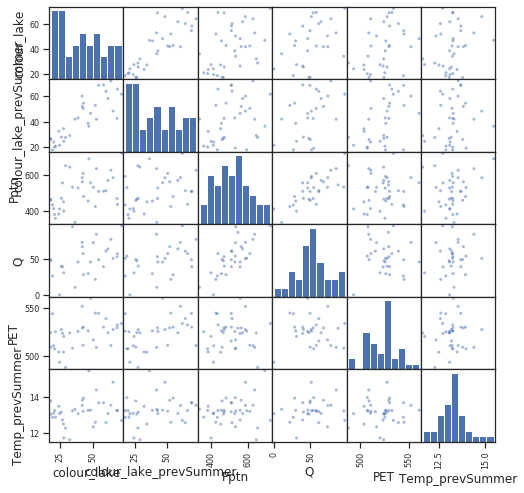

In [159]:
vars_for_scatterplot = ['colour_lake', 'colour_lake_prevSummer', 'Pptn', 'Q','PET','Temp_prevSummer'] #Summer
# vars_for_scatterplot = ['colour_lake', 'Pptn_lag1', 'Q_lag1','colour_lake_prevSummer'] #winter

pd.plotting.scatter_matrix(season_var_df.loc[:,vars_for_scatterplot], figsize=(8,8));

# plt.savefig(os.path.join(graph_outfolder,'seasonal_6M_scattermatrix_colour_%s_%s.png'%(season_slice,basin)))

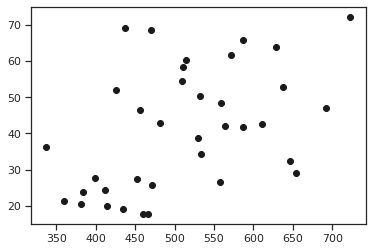

In [160]:
# This plot looked more convincing with met.no precipitation data than it does with ERA5 data...
plt.plot(season_var_df['Pptn'],season_var_df['colour_lake'],'ko')

## Write output csvs split by variable

In [161]:
# season_df_TP.to_csv(os.path.join(out_file,'dataMatrix_seasonal_TP_%s_%s.csv'%(season_slice,basin)), index_label='Date')
# season_df_lake_chla.to_csv(os.path.join(out_file,'dataMatrix_seasonal_Chl-a_%s_%s.csv'%(season_slice,basin)), index_label='Date')
# season_df_cyano.to_csv(os.path.join(out_file,'dataMatrix_seasonal_CyanoBiovol_%s_%s.csv'%(season_slice,basin)), index_label='Date')
# season_df_lakeColour.to_csv(os.path.join(out_file,'dataMatrix_seasonal_colour_lake_%s_%s.csv'%(season_slice,basin)), index_label='Date')

# Write continuous data to csvs for use in BN development

Using results from this notebook (looking at correlations & scatter plots) and feature selection notebooks, pick which variables may be incorporated in the BN (final choice will also depend on practicalities in terms of data availability and cross validation with different BN structures)

## Pick variables to keep and rearrange data

In [21]:
# vars to keep
vars_longnames = [
        'chl-a_lake',
        'chl-a_lake_prevSummer',
        'colour_lake',
        'colour_lake_prevSummer',
        'CyanoBiovol',
#         'CyanoBiovol_prevSummer',
        'Pptn',
#         'Pptn_lag1',
#         'Temp',
        'TP_lake',
        'TP_lake_prevSummer',
        'Wind_speed',
        'Season'
       ]

# Dictionary for renaming variable names
var_dict = {'chl-a_lake': 'chla',
            'chl-a_lake_prevSummer': 'chla_prevSummer',
            'colour_lake': 'colour',
            'colour_lake_prevSummer': 'colour_prevSummer',
            'CyanoBiovol': 'cyano',
#             'CyanoBiovol_prevSummer': 'cyano_prevSummer',
            'Pptn': 'rain',
#             'Pptn_lag1': 'rain_lag1',
#             'Temp':'Temp',
            'TP_lake': 'TP',
            'TP_lake_prevSummer': 'TP_prevSummer',
            'Wind_speed': 'wind_speed',
            'Season':'season'
            }

unchanged_var_names = ['Temp']

# Drop variables which won't be used in the analysis
df_bn = season_df.loc[:,vars_longnames]

# Rename column names using new short names
for var in df_bn.columns:
    df_bn[var_dict[var]] = df_bn[var]
    
    # N.B. any variables which have same names in both sides of the dict need to be in this if loop
    if var not in unchanged_var_names:
        df_bn.drop(var, axis=1, inplace=True)
        
df_bn.tail()

,chla,chla_prevSummer,colour,colour_prevSummer,cyano,rain,TP,TP_prevSummer,wind_speed,season
Date,,,,,,,,,,
2017-04-30,11.000000,9.590909,62.000000,52.0,0.018,307.789680,17.000000,18.750000,3.664088,wint
2017-10-31,12.866667,9.590909,42.000000,52.0,0.258,570.221295,19.666667,18.750000,3.710326,summ
2018-04-30,5.500000,12.866667,71.000000,42.0,0.002,372.847838,24.000000,19.666667,3.439227,wint
2018-10-31,10.741667,12.866667,36.333333,42.0,0.614,312.809003,18.666667,19.666667,3.968478,summ
2019-04-30,4.500000,NaN,59.000000,NaN,0.006,405.441841,22.000000,NaN,3.456906,wint


In [22]:
df_li = []

# COMMENTED OUT BIT BELOW WAS FOR WHEN I WAS DOING WINTER COLOUR AS WELL AS SUMMER. NOT DOING FOR NOW.
# # Split lake colour into two columns - winter and summer
# for season in ['summ','wint']:
#     colour_df = df_bn.loc[df_bn['season']==season, ['colour','rain_lag1']] # Just pick season of interest
    
#     # Add year column and reindex using year
#     colour_df['year'] = colour_df.index.year
#     colour_df.set_index('year', inplace=True)
    
#     new_names = {'summ':{'colour':'colour_summer'},
#                  'wint':{'colour':'colour_winter','rain_lag1':'rain_prevSummer'}}
#     colour_df.rename(columns = new_names[season], inplace=True)
    
#     if season == 'summ':
#         colour_df.drop('rain_lag1', axis=1, inplace=True)
    
#     df_li.append(colour_df)
# summer_df = df_bn.loc[df_bn['season']=='summ', ~df_bn.columns.isin(['colour','rain_lag1','season'])]

# For everything else, only interested in the summer values
summer_df = df_bn.loc[df_bn['season']=='summ', ~df_bn.columns.isin(['season'])]
# Add year column and reindex using year
summer_df['year'] = summer_df.index.year
summer_df.set_index('year', inplace=True)
df_li.append(summer_df)

# Join new annual dfs into one
cont_df = pd.concat(df_li, axis=1)
cont_df.head()

,chla,chla_prevSummer,colour,colour_prevSummer,cyano,rain,TP,TP_prevSummer,wind_speed
year,,,,,,,,,
1980,16.080130,NaN,NaN,NaN,NaN,579.570268,43.573016,NaN,3.341848
1981,8.331250,16.08013,NaN,NaN,NaN,494.730157,28.833333,43.573016,3.488587
1982,5.975000,8.33125,26.666667,NaN,NaN,458.474789,26.988095,28.833333,3.818478
1983,6.050000,5.97500,17.625000,26.666667,NaN,466.631052,29.781250,26.988095,4.247283
1984,11.611111,6.05000,NaN,17.625000,NaN,561.472065,27.158333,29.781250,3.796739


## Time series

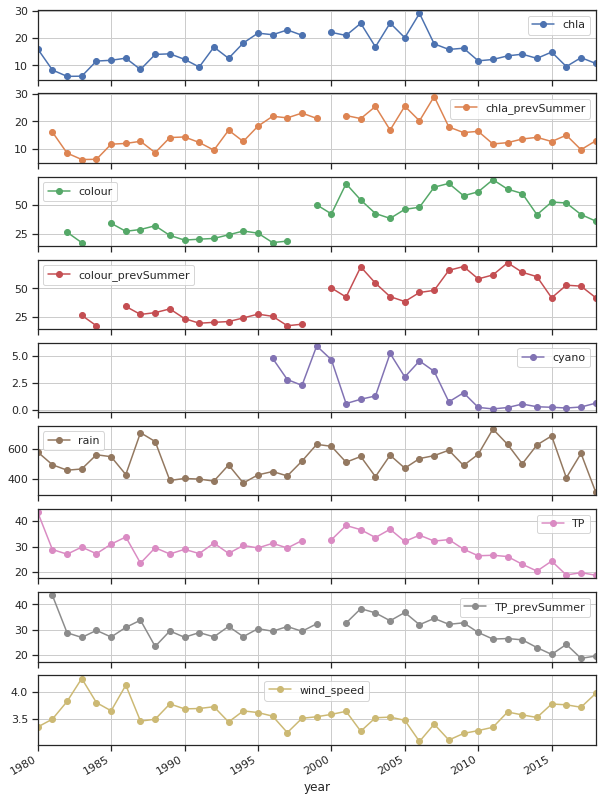

In [23]:
# Plot time series and save figures
cont_df.plot(subplots=True, figsize=(10,15), grid=True, marker='o');
plt.savefig(os.path.join(graph_outfolder,'Vansjø_6M_timeseries_%s.png' %met_source))

In [24]:
cont_df.head()

,chla,chla_prevSummer,colour,colour_prevSummer,cyano,rain,TP,TP_prevSummer,wind_speed
year,,,,,,,,,
1980,16.080130,NaN,NaN,NaN,NaN,579.570268,43.573016,NaN,3.341848
1981,8.331250,16.08013,NaN,NaN,NaN,494.730157,28.833333,43.573016,3.488587
1982,5.975000,8.33125,26.666667,NaN,NaN,458.474789,26.988095,28.833333,3.818478
1983,6.050000,5.97500,17.625000,26.666667,NaN,466.631052,29.781250,26.988095,4.247283
1984,11.611111,6.05000,NaN,17.625000,NaN,561.472065,27.158333,29.781250,3.796739


In [25]:
cont_df.tail()

,chla,chla_prevSummer,colour,colour_prevSummer,cyano,rain,TP,TP_prevSummer,wind_speed
year,,,,,,,,,
2014,12.600000,14.138462,41.863636,60.223077,0.283,626.732204,20.300000,22.992308,3.519890
2015,14.925000,12.600000,52.833333,41.863636,0.233,686.892707,24.250000,20.300000,3.771196
2016,9.590909,14.925000,52.000000,52.833333,0.166,408.035955,18.750000,24.250000,3.755978
2017,12.866667,9.590909,42.000000,52.000000,0.258,570.221295,19.666667,18.750000,3.710326
2018,10.741667,12.866667,36.333333,42.000000,0.614,312.809003,18.666667,19.666667,3.968478


## Fill NaNs & make continuous dfs for BN cross validation

Currently the data cover the period 1980-2018/19, but with the following gaps:
- Quite a few gaps in colour:
    * Summer colour: just a couple of missing years, including 1 at the start. **linearly interpolate or backward fill**
    * Winter colour: only have 20 data points. There's a reasonable relationship between summer and winter colour. For now, **fill in the values back to cover the same dates as cyanobacteria using a regression between summer and winter colour**: winter colour = 0.81 colour_summer + 23.8
- All cols 'prevSummer' are missing data in 1980. Therefore: **drop 1980**
- No TP or chl-a data was collected in 1999. Correspondingly, blanks in TP_prevSummer and chla_prevSummer for 2000. **linearly interpolate**.
- **If using met.no data**, only have data up until mid 2019 so **Drop 2019**. Otherwise, keep it in.
- cyanobacteria:
    * if cyano_prevSummer is included as predictor variable, then first year is 1997 and drop all before
    * otherwise, **first year is 1996, drop all before**.
    
For cross validation, can't have NaNs. Don't want to just drop all NaNs though, as have much less cyano data than have TP and chl-a data. Therefore make two different dataframes for cross validation, one for TP and chl-a that includes all years, and excludes cyano. One for cyano and colour. Can't include summer colour in the TP and chl-a one despite having lots of data, because they're linked via cyano. Not sure how valid the cross val will be in this case, as the final network I'll be using will be different to the ones used in cross val... But it's a start anyway. To improve on, need to write own function to allow cross val to be able to cope with missing values.

### Continuous dataframe, all data

In [26]:
# Truncate start and end years
if met_source == 'metno':
    end_yr = 2018
else:
    end_yr = 2019
cont_df = cont_df.loc[1981:2019,:]

# Linearly interpolate gaps of size 1
cont_df.interpolate(method='linear',limit=1, inplace=True)

# Backwards fill summer colour NaNs at start of record (summer colour and previous summer's colour)
for col in ['colour','colour_prevSummer']:
    cont_df[col] = cont_df[col].fillna(method='bfill', limit=2)

cont_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,chla,chla_prevSummer,colour,colour_prevSummer,cyano,rain,TP,TP_prevSummer,wind_speed
year,,,,,,,,,
1981,8.331250,16.080130,26.666667,26.666667,NaN,494.730157,28.833333,43.573016,3.488587
1982,5.975000,8.331250,26.666667,26.666667,NaN,458.474789,26.988095,28.833333,3.818478
1983,6.050000,5.975000,17.625000,26.666667,NaN,466.631052,29.781250,26.988095,4.247283
1984,11.611111,6.050000,26.014881,17.625000,NaN,561.472065,27.158333,29.781250,3.796739
1985,11.895238,11.611111,34.404762,26.014881,NaN,548.374613,30.957143,27.158333,3.644022


In [27]:
# Check for NaNs
cont_df[['colour','colour_prevSummer']].isna().sum().sum()

0

### Regression to help fill colour data gaps

Code below isn't working now that I decided not to include winter colour in BN. But regression was good:
Equation: colour_winter = 0.97 * colour_summer + 13.96. R2 0.67, adj. R2 0.65. Intercept not significant (p0.09)
i.e. almost a 1:1, but with a constant offset.

In [169]:
# import statsmodels.formula.api as sm
# result = sm.ols(formula="colour_winter ~ colour_summer", data=cont_df).fit()
# print(result.params)
# print(result.summary())

In [170]:
# plt.plot(cont_df['colour_summer'],cont_df['colour_winter'],'ko');

### Cyano and colour dataframe

In [28]:
# Make cyanobacteria and lake winter colour dataframe (all data or just nodes directly linked to cyano and colour)

# Drop missing data from start
cont_df_cyano_colour = cont_df.copy().loc[1996:,:]

# Fill winter colour NaNs at start of record (3, 1996-1998) using summer colour
# (Not doing for now)
# cont_df_cyano_colour.loc[cont_df_cyano_colour['colour_winter'].isna()==True,"colour_winter"] = cont_df_cyano_colour.loc[cont_df_cyano_colour['colour_winter'].isna()==True,"colour_summer"] * 0.81 + 23.8

# Select variables directly involved in cyanobacterial BN
cont_df_cyano_colour_directVars = cont_df_cyano_colour.loc[:,
                                 ['cyano',
                                  'chla',
                                  'colour',
#                                   'rain_prevSummer', # This and all below are colour-related
                                  'colour_prevSummer',
#                                   'colour_winter',
                                'rain']]

# Check for NaNs
print('Number of NaNs: %s' %cont_df_cyano_colour.isna().sum().sum())
print('Number of NaNs: %s' %cont_df_cyano_colour_directVars.isna().sum().sum())

# cont_df_cyano_colour.head()
cont_df_cyano_colour_directVars.head()

Number of NaNs: 0
Number of NaNs: 0


,cyano,chla,colour,colour_prevSummer,rain
year,,,,,
1996,4.80,21.300000,17.666667,25.833333,449.609513
1997,2.82,23.066667,19.000000,17.666667,420.429376
1998,2.28,21.100000,34.711538,19.000000,519.280270
1999,5.96,21.633333,50.423077,34.711538,630.476421
2000,4.67,22.166667,42.560000,50.423077,617.658010


### TP and chl-a dataframe

In [29]:
# Drop cyanobacteria & winter colour, and related variables, from TP and chl-a dataframe
cont_df_noCyano = cont_df.drop(['cyano',
#                                 'colour_winter',
#                                 'rain_prevSummer',
                                ],
                                 axis=1)

# Backwards fill summer colour NaNs
cont_df_noCyano.fillna(method='bfill',limit=2,inplace=True)

# Check for NaNs
print('Number of NaNs: %s' %cont_df_noCyano.isna().sum().sum())
cont_df_noCyano.tail()

Number of NaNs: 0


,chla,chla_prevSummer,colour,colour_prevSummer,rain,TP,TP_prevSummer,wind_speed
year,,,,,,,,
2014,12.600000,14.138462,41.863636,60.223077,626.732204,20.300000,22.992308,3.519890
2015,14.925000,12.600000,52.833333,41.863636,686.892707,24.250000,20.300000,3.771196
2016,9.590909,14.925000,52.000000,52.833333,408.035955,18.750000,24.250000,3.755978
2017,12.866667,9.590909,42.000000,52.000000,570.221295,19.666667,18.750000,3.710326
2018,10.741667,12.866667,36.333333,42.000000,312.809003,18.666667,19.666667,3.968478


### Continuous dfs to csv

In [30]:
cont_df.to_csv(os.path.join(out_file, 'forCrossValidation/Untransformed/%s/Vansjo_Seasonal_6M_Continuous_all.csv' %met_source))
cont_df_cyano_colour.to_csv(os.path.join(out_file, 'forCrossValidation/Untransformed/%s/Vansjo_Seasonal_6M_Continuous_cyanoColour_allVars.csv' %met_source))
cont_df_cyano_colour_directVars.to_csv(os.path.join(out_file, 'forCrossValidation/Untransformed/%s/Vansjo_Seasonal_6M_Continuous_cyanoColour_directVars.csv' %met_source))
cont_df_noCyano.to_csv(os.path.join(out_file, 'forCrossValidation/Untransformed/%s/Vansjo_Seasonal_6M_Continuous_noCyano.csv' %met_source))

# Transform continuous data to make ~Gaussian

It could be good for the BN to be continuous rather than discrete, but BNLearn assumes all nodes are Gaussian. From a look at the histograms above most aren't far off bell-shaped, aside from cyanobacteria and perhaps colour.

## Cyano
For cyanobacteria, the distribution is right-skewed and has lots of zeros. In reality these won't really be zeros, just below the counting detection limit. So some kind of transformation is required which can cope with zeros.

Find a box cox transformation works ok:

 y* = (y^L - 1)/L
 
where L != 0. L close to 0 is a near-logorithmic transformation. From some trial and error, find that lambda (L) between 0.06 and 0.2 produces roughly symmetrical data. Doesn't look  bell shaped, but that could easily be because of the low n. No reason to pick any particular number between 0.06 and 0.2, so decide to go with 0.1 as an even number.

Will then need to back-transform the predictions later: y = (x*lambda + 1)^(1/lambda)

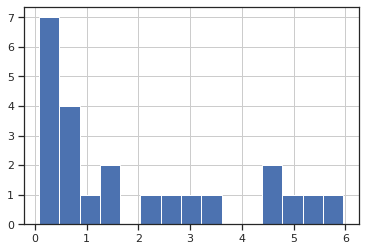

In [31]:
# Original data
cont_df['cyano'].hist(bins=15)

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1038: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


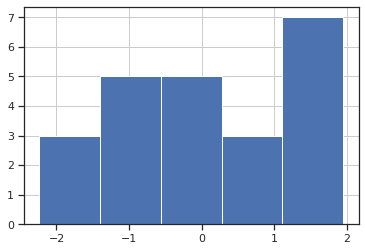

In [32]:
# Try box cox

from scipy.stats import boxcox
bs = boxcox(cont_df['cyano'].values, lmbda=0.1)

trans_df = pd.DataFrame(index = cont_df.index)
trans_df['original'] = cont_df['cyano']
trans_df['boxcox'] = bs

trans_df['boxcox'].hist(bins=5)

In [33]:
# Copy original dfs and transform

df_dict = {'all':cont_df,
          'cyanoColour_allVars':cont_df_cyano_colour,
          'cyanoColour_directVars':cont_df_cyano_colour_directVars,
#           'noCyano':cont_df_noCyano
          }
keyLi = list(df_dict.keys())

for key in keyLi:
    df_boxcx = df_dict[key].copy()
    # Apply transformation
    for col in ['cyano']:
        df_boxcx[col] = boxcox(df_boxcx[col].values, lmbda=0.1)
    
    # Save to csv
    pathname = os.path.join(out_file, 'forCrossValidation/Transformed/%s/Vansjo_6M_Continuous_%s_boxcox.csv' %(met_source,key))
    df_boxcx.to_csv(pathname)

#     # Plot histogram again
#     axes = cont_df_cyano_boxcx.hist(bins=6, figsize=(8,8), grid=False)

# Discretized input for BN

First, need to pick class boundaries. Do this based on regression tree analysis and WFD class boundaries

Pick class boundaries from examination of regression trees and scatter plots, and for each variable plot where they lie to see how many data points we will have in each class (not considering joint classes for now)

Notes for particular variables:
TP: WFD class boundaries are 20.0 and 39.0 ug/l. However, pretty much all data are within the 'moderate' class between these two bounds, leading to no data issues when we try to link TP to other nodes. So reduce to just two categories, above or below the midpoint of the 'Moderate' ecological status class.

## Pick class boundaries

In [34]:
# Dictionary with key: target var, returns list of potential explanatory vars
xy_dict = {'TP': ['TP_prevSummer', 'wind_speed'],
           'colour': ['colour_prevSummer','rain'],
#            'colour_winter': ['colour_prevSummer','rain_prevSummer'],
           'chla': ['TP','chla_prevSummer', 'wind_speed'],
           'cyano': ['chla','colour']}

# Regression tree, one for each pair of explanatory - dependent variable
for targetvar in xy_dict.keys():
    for xvar in xy_dict[targetvar]:
        temp_df = cont_df[[targetvar]+[xvar]].dropna()
        y = temp_df[targetvar].values # Target variable data
        y = y.reshape(-1, 1)
        X = temp_df[xvar].values # Explanatory var data
        X = X.reshape(-1,1)
        regressor = DecisionTreeRegressor(random_state=0,
                                      max_depth=4,
                                      min_samples_split=6,
                                      min_samples_leaf=3,
                                      max_leaf_nodes=8
                                     )
        regressor.fit(X,y)

        # export the decision tree to a tree.dot file for visualizing the plot easily anywhere
        dot_fpath = os.path.join(graph_outfolder, 'Discretization_regTrees/Pairwise/DotFiles/%s_6Mseasons_%s-%s.dot' %(met_source,targetvar,xvar))
        export_graphviz(regressor, out_file =dot_fpath, feature_names = [xvar])

        # Convert .dot file to .png
        png_fpath = os.path.join(graph_outfolder, 'Discretization_regTrees/Pairwise/6MSeasons/%s/6MSeasons_%s-%s.png' %(met_source,targetvar,xvar))
        pgv.AGraph(dot_fpath).draw(png_fpath, format='png', prog='dot')

In [179]:
# # For winter colour, don't have WFD or management-relevant class boundaries. So just define using terciles for now
# for q in [0.33, 0.66]:
#     print('Q: %s' %cont_df['colour_winter'].quantile(q))

In [36]:
# For wind speed, no obvious step change on scatter plot, and regression tree-based boundary makes
# unbalanced classes. Try just median instead

for var in ['wind_speed','TP_prevSummer']:
    print('Median %s: %s' %(var,cont_df[var].quantile(0.5)))

Median wind_speed: 3.555706521739131
Median TP_prevSummer: 29.491666666666667


In [37]:
bound_dict = {
             'TP': [29.5], # No data below 20, so drop this class boundary. 29.5 is middle of 'Mod' class
             'TP_prevSummer': [29.5], #Was [26.8, 31.7], but too many classes. Just have 2.
             'chla': [20.0],  # WFD boundaries: [10.5, 20.0]. But only 6 d.p. under 10.5 so merge G and M classes.
                              # For predicting cyano, would be better 17.4.   
             'chla_prevSummer': [16.8], # from RT
             'colour': [51.2], # Pick class purely for cyano prediction
#              'colour_winter': [60.6, 69.8], # Terciles
             'colour_prevSummer': [32.6, 61.0],
             'cyano': [1.0], # M-P boundary is 2.0, but there were only 2 values in this class. Plenty above 2 tho.
             'rain': [497],
#              'rain_prevSummer': [563],
#              'wind_speed': [3.56], # [3.64] from regression tree (mean of TP and chla), but classes too unbalanced
            }

# Add wind speed threshold, which depends on whether met.no or era5 is being used
wind_speed_dict = {'metno':[3.56], 'era5':[2.5]}
bound_dict['wind_speed'] = wind_speed_dict[met_source]

bound_dict_terciles = {}

for var in cont_df.columns:
    bound_dict_terciles[var] = [cont_df[var].quantile(0.333), cont_df[var].quantile(0.667)]

bound_dict_terciles

{'chla': [12.604585714285715, 17.583654571428575],
 'chla_prevSummer': [12.63466666631, 17.583654571428575],
 'colour': [27.54992460392905, 47.74483333333334],
 'colour_prevSummer': [26.92525000035667, 47.74483333333334],
 'cyano': [0.548996, 2.6439600000000008],
 'rain': [461.09294967050795, 557.514145479787],
 'TP': [27.17973333333334, 31.32375],
 'TP_prevSummer': [27.249075000000005, 31.79643757763975],
 'wind_speed': [3.4936461956521745, 3.6434983695652186]}

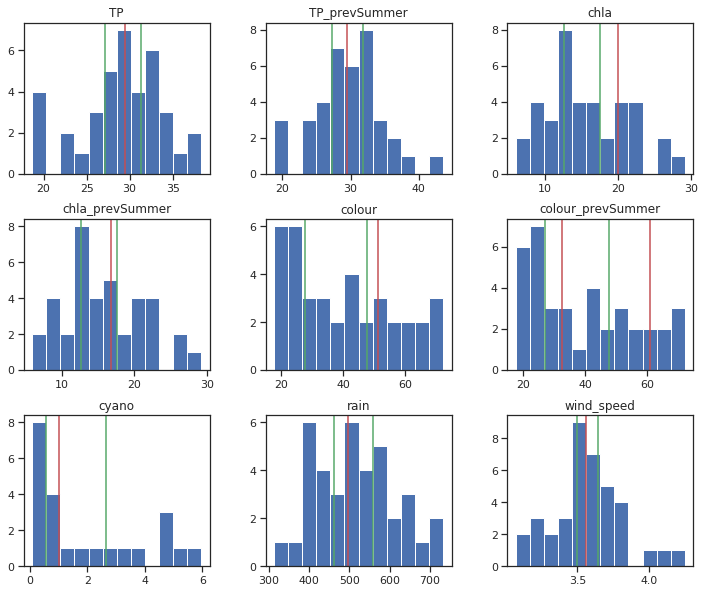

In [38]:
axes = cont_df.sort_index(axis=1).hist(bins=12, figsize=(12,10), grid=False)

# For each subplot, add on vertical lines for the proposed class boundaries
# N.B. assumes order of plots is the same as the order of keys in bound_dict
var_li = sorted(list(bound_dict.keys()))

for i, ax in enumerate(axes.flatten()):
    if i<11:
        lines = bound_dict[var_li[i]]
        for line in lines:
            ax.axvline(x=line, color='r')
        tercile_lines = bound_dict_terciles[var_li[i]]
        for tercLine in tercile_lines:
            ax.axvline(x=tercLine, color='g')

plt.show()

## Discretize

In [39]:
def discretize(thresholds, value):
    
    if np.isnan(value):
        return np.NaN
    
    factor_li_dict = {2: ['L','H'],
                     3: ['L','M','H'],
                     4: ['VL','L','M','H'],
                     5: ['VL','L','M','H','VH']}
    
    n_classes = len(thresholds)+1
    
    for i, boundary in enumerate(thresholds):
    
        if value<boundary:
            return factor_li_dict[n_classes][i]
            break # Break out of loop
        
        # If we're up to the last class boundary, and the value is bigger than it, value is in the uppermost class
        if i+1 == len(thresholds) and value >= boundary:
            return factor_li_dict[n_classes][i+1]


In [40]:
cont_df_li = [cont_df, cont_df_cyano_colour, cont_df_cyano_colour_directVars, cont_df_noCyano]
fname_suffix_li = ['all','cyano_colour_allVars','cyano_colour_localVars','noCyano']

# Dictionary for storing different discretized dfs.
# Key: data included (all data, all data from when cyano measured, just cyano-related vars, no cyano vars;
# from fname_suffix_li). Returns discretized df based on WFD and regression-tree class boundaries
disc_rt_dict = {}

for i, df in enumerate(cont_df_li):

    # Create empty dataframe to be populated with discretized data
    disc_df = pd.DataFrame(index=df.index, columns=df.columns)

    for var in df.columns:
        disc_df[var] = df[var].apply(lambda x: discretize(bound_dict[var], x))
    
    # Store in dictionary
    disc_rt_dict[fname_suffix_li[i]] = disc_df
        
    # Write to csv
    fname = os.path.join(out_file, 'Discretized/%s/Discretized_RegTree_%s.csv' %(met_source, fname_suffix_li[i]))
    disc_df.to_csv(fname)

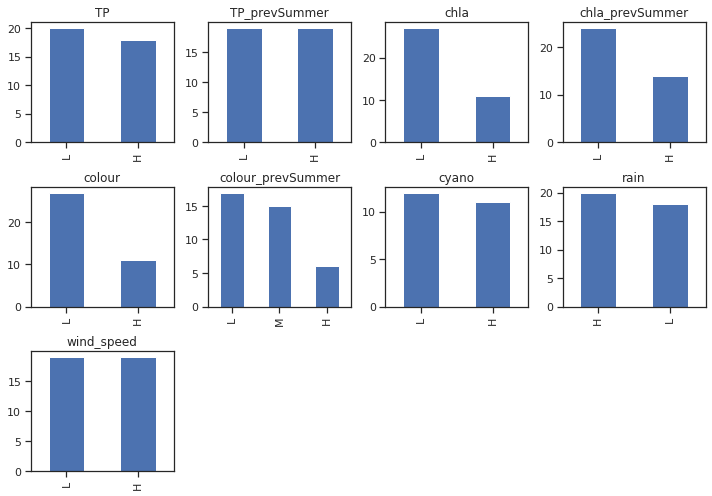

In [41]:
# How balanced are the classes?

# 1) All data and time
disc_df = disc_rt_dict['all'].sort_index(axis=1)

fig, ax = plt.subplots(3,4, figsize=(10,7))
ax = ax.flatten()
for i, categorical_feature in enumerate(disc_df.columns):
    disc_df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)

for axi in ax[-3:]:
    fig.delaxes(axi)
plt.tight_layout()

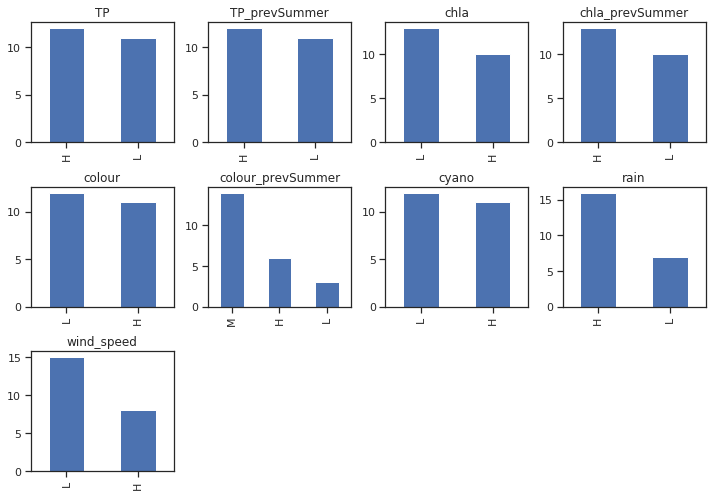

In [42]:
# 1) Cyano and colour df
disc_df = disc_rt_dict['cyano_colour_allVars'].sort_index(axis=1)

fig, ax = plt.subplots(3,4, figsize=(10,7))
ax = ax.flatten()
for i, categorical_feature in enumerate(disc_df.columns):
    disc_df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)

for axi in ax[-3:]:
    fig.delaxes(axi)
plt.tight_layout()

met.no wind speed and rain are very unbalanced for the post 1996 period. i.e. it was basically pretty calm and rainy relative to earlier. So we're just looking mostly at that step-change in these class breaks...
previous summer colour probably has too many classes too, the low class doesn't have much in it. Try it and see how it goes. I'm getting the feeling it's probably better to try a continuous network rather than worry too much about this.